In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange
import io
from PIL import Image
from matplotlib import animation

In [2]:
df = pd.read_csv('../data/minimus-20221209-1945.csv', parse_dates=['datetime'])

Some junk detections lie outside of the experimental chamber. We can roughly crop these off.

In [3]:
df = df[df['z_cm'] > 450]

Let's just focus on the long tracks, longer than 10 seconds long.

In [4]:
long_tracks = []
for group_name, group_df in df.groupby("id"):

    # calculate the length in time of each track
    duration = group_df['datetime'].iloc[-1] - group_df['datetime'].iloc[0]
    duration = duration.total_seconds()

    if duration > 10:
        long_tracks.append(group_name)
        print(f'{group_name}: {duration} seconds')

01GKW6VJ1FY1TRRY7TW69E2SNC: 17.610078 seconds
01GKW6WKH16XNDE8HCSZXQPRR1: 13.58006 seconds
01GKW772JB5XA0PCJT61KSCPBX: 36.600161 seconds
01GKW7BS03CQPE990Y3VCX732M: 14.470064 seconds
01GKW7CCKKV6ETF79D8ZHZX62W: 10.830047 seconds
01GKW7D6TNAF3N1C4SEVVQ3WJ5: 11.52005 seconds
01GKW7DZ12PVN1HNN3JY328RG7: 15.030066 seconds
01GKW7FXY6WDN6XFXRAA53D2K0: 11.820052 seconds
01GKW7G0C0JNHH92TCTFF36KRJ: 10.710047 seconds
01GKW7GSY4K7AJD8MBWK19DZ9T: 18.530082 seconds
01GKW7HC7E6EY3V7NQDMNSWBQE: 14.760065 seconds
01GKW7JWZ440T8KJFEGSQ3APW8: 10.660047 seconds


[Matplotlib 3D view angles](https://matplotlib.org/stable/api/toolkits/mplot3d/view_angles.html) use a view-direction convention that's different than our data.

| mpl | data |
|-----|------|
| x   | z    |
| y   | x    |
| z   | y    |

Let's true plotting these tracks into time.
1. Subset by the track(s) we want to plot
2. Send the tracks and the times into the function (we can't subset yet, because we want a very consistent timeline)
3. In the function subset the dataset and plot, but the time listed should be

In [32]:
def plot_tail(ax, _group_df, time_end, color, length=1.0, steps=10):
    
    """
    Create a fading tail after the current time. 
    """

    increments = np.linspace(0, length, steps+1)[1:]
    for increment in np.linspace(0, length, steps+1)[1:]:
        stime = time_end - pd.Timedelta(f'{increment}s')
        ax.plot(_group_df['z_cm'].loc[stime:time_end], _group_df['x_cm'].loc[stime:time_end],
            _group_df['y_cm'].loc[stime:time_end], alpha=0.1, linewidth=5, color=color)
    return ax

def plot_frame(
    tracks,
    time_start=None,
    time_end=None,
    elev=10,
    azim=190,
    roll=0,
    title='',
    legend=False,
    data_limits=False
):
    """
    A frame of our animation, starting at the beginning of the data and going to the
    time provided.
    """

    #subset our tracks by the time
    _df = tracks.loc[time_start:time_end]
    elapsed_time = (time_end - time_start).total_seconds()
    elapsed_time_label = f'{elapsed_time:.02f}'

    fig = plt.figure(dpi=72, figsize = (20, 11.25))
    ax = fig.add_axes([0,0,1,1], projection = '3d')

    # plot each group individually based on their id
    for group_name, group_df in _df.groupby("id"):
        color='C0'

        # whole track
        ax.plot(group_df['z_cm'], group_df['x_cm'], group_df['y_cm'], label=group_name, alpha=0.3)

        ax = plot_tail(ax, group_df, time_end, color, length=1, steps=10)

        last_location = group_df.iloc[-1]
        ax.plot(last_location['z_cm'], last_location['x_cm'], last_location['y_cm'],
            marker='o', markersize=15, markerfacecolor='black',
            markeredgecolor='white', markeredgewidth=2.0,
            linestyle='None'
        )
    
    ax.view_init(elev=elev, azim=azim, roll=roll)
    ax.set_xlabel('z_cm')
    ax.set_ylabel('x_cm')
    ax.set_zlabel('y_cm')

    if legend:
        ax.legend(loc='upper left', ncols=3, columnspacing=1, frameon=False, fontsize=8,
        borderpad=1.0)

    ax.set_aspect('equal', adjustable='box')

    if not data_limits:
        ax.set_xlim(450, 1050)
        ax.set_ylim(-160, 160)
        ax.set_zlim(-160, 160)
    
    ax.text2D(0.05, 1.02, title,
        fontsize=24, ha='left', va='bottom', linespacing=1.4, transform=ax.transAxes)
    
    ax.text2D(0.95, 1.02, f'{elapsed_time_label} seconds',
        fontsize=24, ha='right', va='bottom', linespacing=1.4, transform=ax.transAxes)

    # save and pass back
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches='tight', format='PNG')
    #fig.savefig(buf, format='PNG')
    plt.close(fig)
    
    return Image.open(buf)

In [33]:
sub = df[df['id'] == long_tracks[9]].copy()
# sub = df[df['id'].isin(long_tracks)].copy()
sub.index = sub['datetime']

timeline = pd.date_range(start=sub.index[0], end=sub.index[-1], freq='10L')
camera_elev = np.linspace(10, 20, num=len(timeline))
camera_azim = np.linspace(190, 200, num=len(timeline))

In [38]:
i=1850
img = plot_frame(sub, time_start=timeline[0], time_end=timeline[i], title=long_tracks[9])

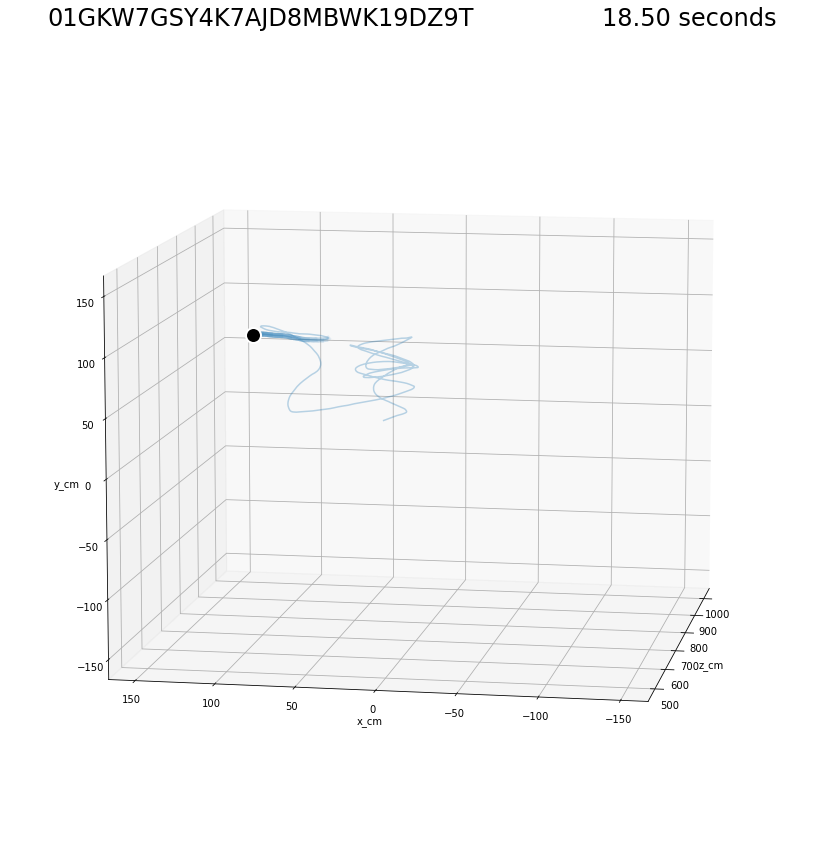

In [39]:
img

In [40]:
from dask.distributed import Client, LocalCluster
from distributed import progress
import multiprocessing as mp

with LocalCluster(n_workers=int(0.9 * mp.cpu_count()),
    processes=True,
    threads_per_worker=1,
    memory_limit='2GB'
) as cluster, Client(cluster) as client:

    futures = [client.submit(
        plot_frame, sub, time_start=timeline[0], time_end=timeline[i], title=long_tracks[9],
        ) for i in range(0, len(timeline))]

    results = client.gather(futures, 'skip')

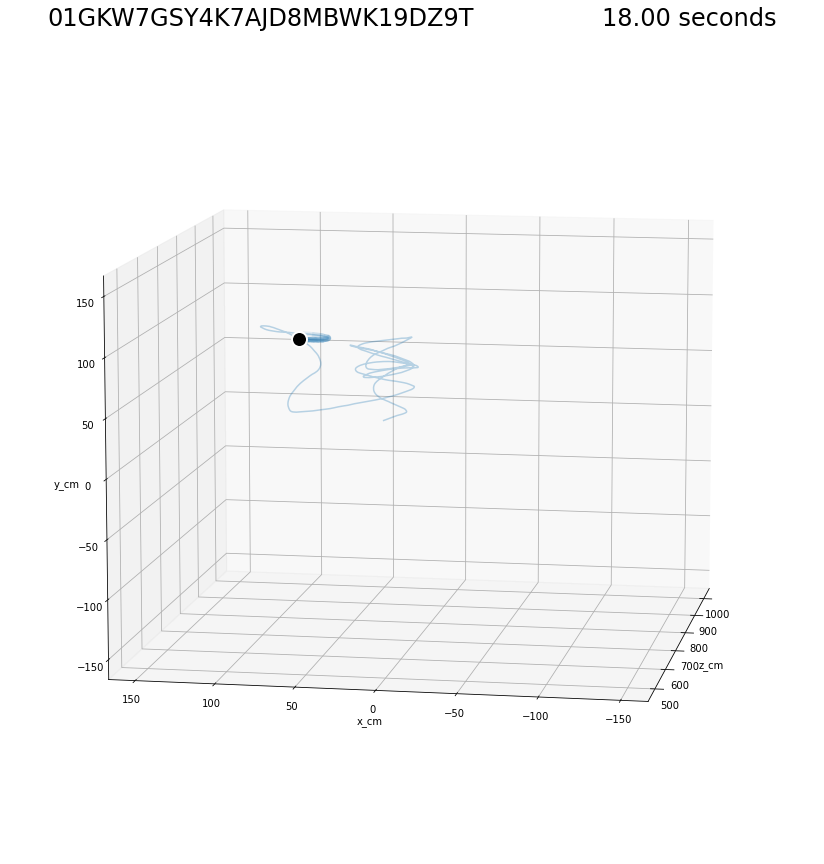

In [41]:
results[1800]

In [42]:
# bring in a list of images and write to an output file

def make_movie_mp4(image_array, output_file, fps_count=24*4):
    dpi = 72.0
    width, height = image_array[0].size[0], image_array[0].size[1]
    
    # make frames with each figure being the exact dimensions of our plots
    fig = plt.figure(figsize=(width/dpi, height/dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im)
    
    mywriter = animation.FFMpegWriter(fps=fps_count, bitrate=-1)
    anim = animation.FuncAnimation(fig, animate, frames=len(image_array), interval=(1./fps_count * 1000.))
    
    anim.save(output_file, mywriter)
    
    return anim

In [43]:
%%time
# use our function to make the movie
anim = make_movie_mp4(results, f'../outputs/{long_tracks[9]}-video-withtail.mp4')

CPU times: user 1min 35s, sys: 1.68 s, total: 1min 37s
Wall time: 1min 38s


<Figure size 824x864 with 0 Axes>

## Tail Work

In [190]:
print(i)

1700


<function matplotlib.pyplot.show(close=None, block=None)>

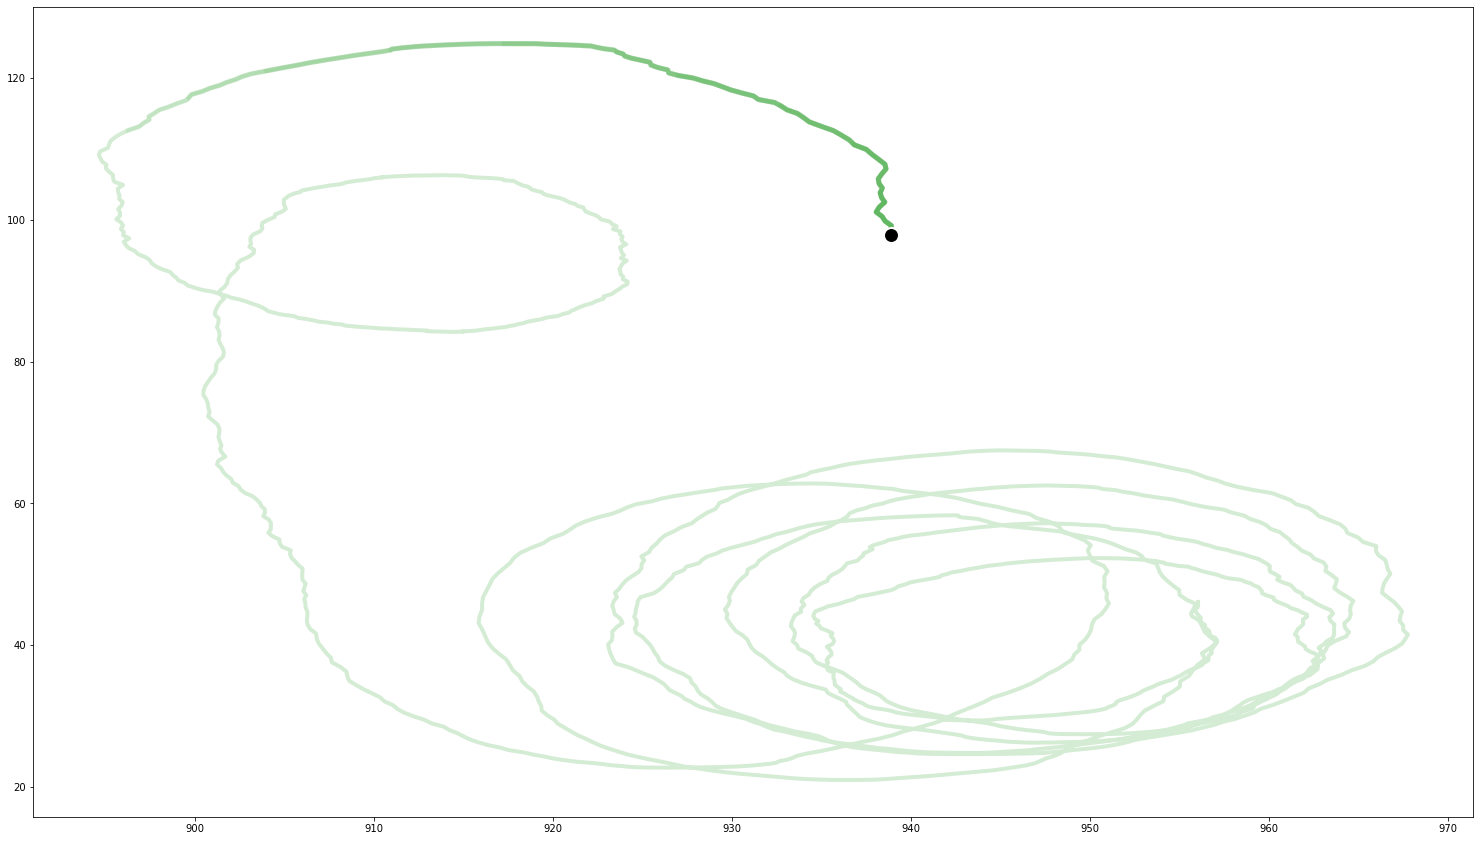

In [189]:
def plot_tail(ax, time_end, color, length=1.0, steps=10):
    increments = np.linspace(0, length, steps+1)[1:]
    for increment in np.linspace(0, length, steps+1)[1:]:
        stime = time_end - pd.Timedelta(f'{increment}s')
        ax.plot(group_df['z_cm'].loc[stime:time_end], group_df['x_cm'].loc[stime:time_end],
            alpha=0.1, linewidth=5, color=color)
    return ax

time_start = timeline[0]
time_end = timeline[i]
fig = plt.figure(dpi=72, figsize = (20, 11.25))
ax = fig.add_axes([0,0,1,1])

#subset our tracks by the time
_df = sub.loc[time_start:time_end]
elapsed_time = (time_end - time_start).total_seconds()
elapsed_time_label = f'{elapsed_time:.02f}'

# plot each group individually based on their id
id_groups = _df.groupby('id')

for group_name, group_df in id_groups:

    color='C2'
    # whole track
    ax.plot(group_df['z_cm'], group_df['x_cm'], alpha=0.2, color=color, linewidth=4)

    ax = plot_tail(ax, time_end, color, length=1, steps=10)

    last_location = group_df.iloc[-1]
    ax.plot(last_location['z_cm'], last_location['x_cm'], marker='o', markersize=15, markerfacecolor='black',
        markeredgecolor='white', markeredgewidth=2.0, linestyle='None')
plt.show

In [102]:
group_df.index[-1] - pd.Timedelta('1s')

Timestamp('2022-12-09 19:59:28.960550')

In [101]:
pd.Timedelta('1s')

Timedelta('0 days 00:00:01')